In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

In [18]:
# 배치크기 * 채널 (1: 그레이스케일, 3: 컬러) * 높이 * 너비
inputs = torch.Tensor(1, 1, 28, 28)
print(inputs.shape)

torch.Size([1, 1, 28, 28])


In [19]:
# 첫번째 Conv2D
conv1 = nn.Conv2d(in_channels = 1, out_channels=32, kernel_size=3, padding='same') # padding: inputs의 크기를 유지시켜줘
out = conv1(inputs)
print(out.shape)

torch.Size([1, 32, 28, 28])


In [20]:
# 첫번째 MaxPool2D
pool = nn.MaxPool2d(kernel_size=2)
out = pool(out)
print(out.shape)

torch.Size([1, 32, 14, 14])


In [21]:
# 두번째 Conv2D
conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same') # conv1의 out의 채널이기 때문에 32
out = conv1(out)
print(out.shape)

torch.Size([1, 64, 14, 14])


In [22]:
# 두번째 MaxPool2D
pool = nn.MaxPool2d(kernel_size=2)
out = pool(out)
print(out.shape)

torch.Size([1, 64, 7, 7])


In [23]:
flatten = nn.Flatten()
out = flatten(out)
print(out.shape)

torch.Size([1, 3136])


In [24]:
# Fully Connected
fc = nn.Linear(3136, 10)
out = fc(out)
print(out.shape)

torch.Size([1, 10])


# CNN으로 MNIST 분류하기

In [27]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [30]:
train_data = datasets.MNIST (
    root = 'data',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

test_data = datasets.MNIST (
    root = 'data',
    train = False,
    transform = transforms.ToTensor(),
    download = True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 117316596.29it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25310424.95it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34005779.48it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22049223.11it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [31]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


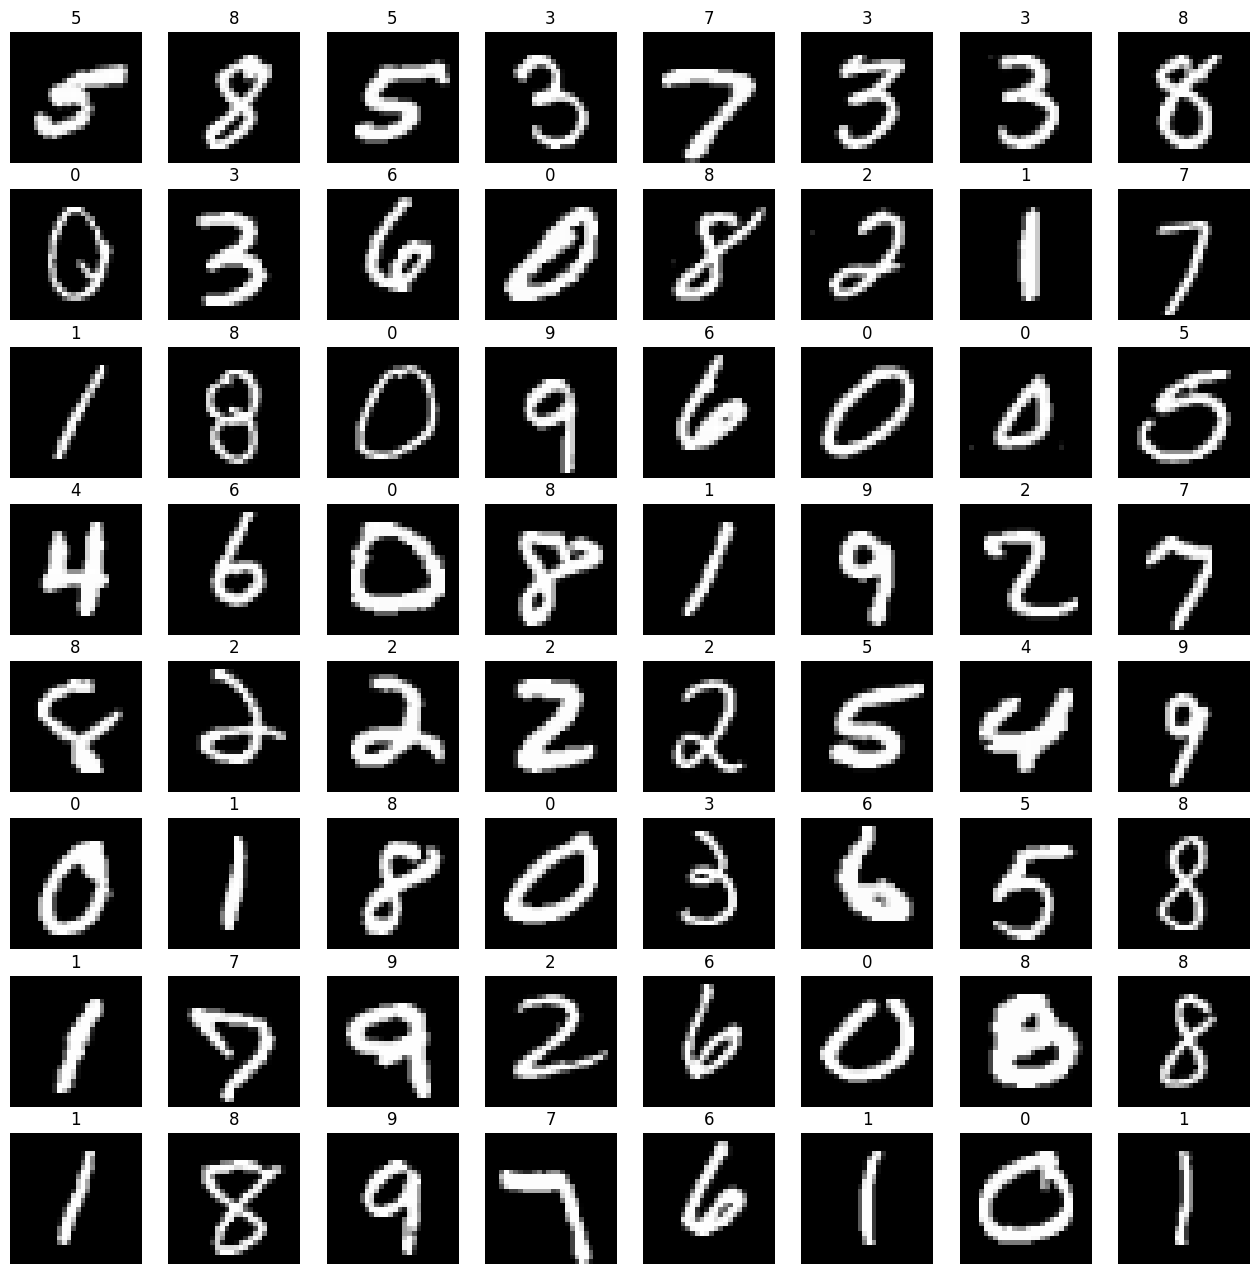

In [41]:
# 8*8 형태로 출력
# DataLoader 만들기
# batch_size=64, shuffle=True


# DataLoader란 전체 데이터셋에서 몇개의 데이터를 넣어서 학습 시킬거냐
# 여기선 train_data에서 64개의 batch size로 셔플해서 학습시켜줘
loader = DataLoader(
    dataset = train_data,
    batch_size = 64,
    shuffle=True
)

imgs, labels = next(iter(loader))

fig, axes = plt.subplots(8,8, figsize=(16,16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
  ax.imshow(img.reshape((28,28)), cmap='gray')
  ax.set_title(label.item())
  ax.axis('off')

In [36]:
# print(imgs)

In [37]:
# print(labels)

In [43]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(7 * 7 * 64, 10) # output이 10개
).to(device)

print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=10, bias=True)
)


In [ ]:
# 학습
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs=10

for epoch in range(epochs):
    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)

        loss = nn.CrossEntropyLoss()(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_losses = sum_losses + loss.item()
        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100

        sum_accs = sum_accs + acc.item()
    avg_loss = sum_losses / len(loader)
    avg_acc = sum_accs / len(loader)

    print(f'Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc: .2f}%')

Epoch    1/10 Loss: 0.186679 Accuracy:  94.31%
Epoch    2/10 Loss: 0.056439 Accuracy:  98.21%
Epoch    3/10 Loss: 0.041324 Accuracy:  98.73%
Epoch    4/10 Loss: 0.033104 Accuracy:  98.99%
Epoch    5/10 Loss: 0.026716 Accuracy:  99.16%
Epoch    6/10 Loss: 0.022253 Accuracy:  99.30%
Epoch    7/10 Loss: 0.018320 Accuracy:  99.42%


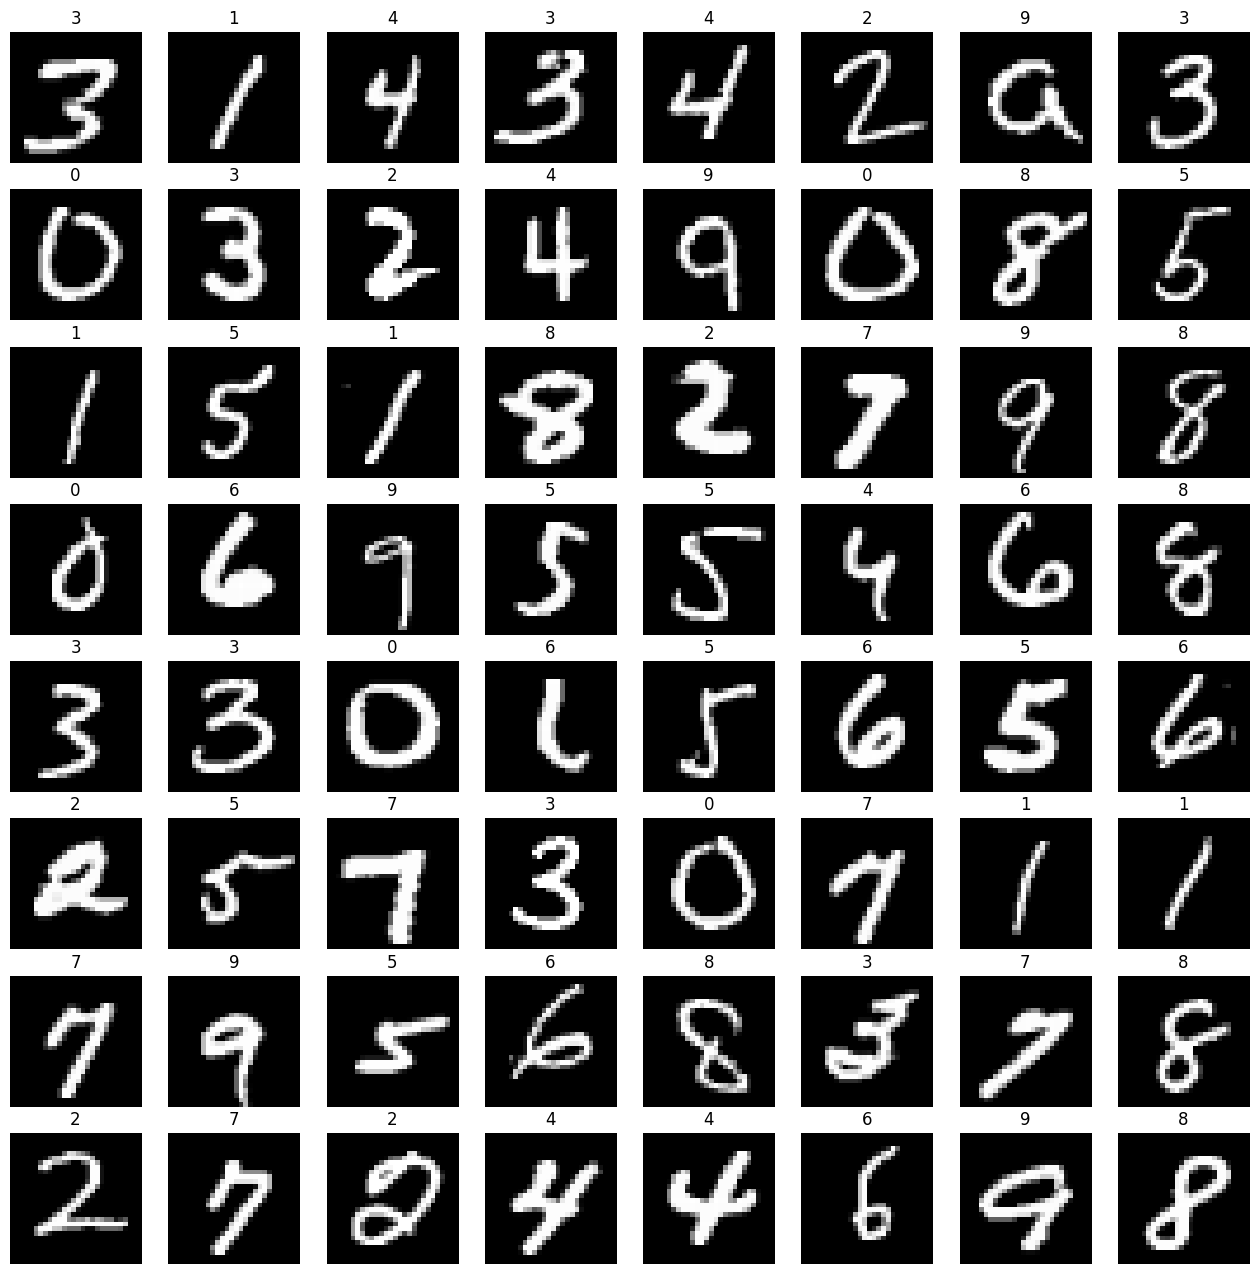

In [46]:
test_loader = DataLoader(
    dataset = test_data,
    batch_size = 64,
    shuffle = True
)

imgs, labels = next(iter(test_loader))

fig, axes = plt.subplots(8,8, figsize=(16,16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
  ax.imshow(img.reshape((28,28)), cmap='gray')
  ax.set_title(label.item())
  ax.axis('off')

In [47]:
model.eval() # 모델을 테스트 모드로 전환

sum_accs = 0

for x_batch, y_batch in test_loader:
  x_batch = x_batch.to(device)
  y_batch = y_batch.to(device)

  y_pred = model(x_batch)

  y_prob = nn.Softmax(1)(y_pred)
  y_pred_index = torch.argmax(y_prob, axis=1)
  acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100

  sum_accs = sum_accs + acc.item()

avg_acc = sum_accs / len(test_loader)

print(f'테스트 정확도는 {avg_acc:2f}% 입니다!')

테스트 정확도는 98.805732% 입니다!
